# 1. CGP controller to solve the movement of the mouse issue 

In [1]:
import numpy as np
from collections import deque
from pyCGP.pycgp.evaluator import Evaluator
import matplotlib.pyplot as plt
from pyCGP.pycgp.cgpfunctions import *
from pyCGP.pycgp import CGP, CGPES
import os
import sys
from IPython.display import display
# Add the parent directory (two levels up) to sys.path
sys.path.append(os.path.abspath(os.path.join('..', '..')))
sys.path.append(os.path.abspath(os.path.join('..')))
import time
import yaml
from utils import *
from common.tools import stack



# get the data from data set

In [2]:
log_file_path = "../environment/logs/dataset_test/cos_with_jittering_joao.log"

bx, by, px, py, mdx, mdy, score, time, dbx, dby, dataframe = read_data(log_file_path)

display(dataframe)

,Bx,By,Px,Py,Mdx,Mdy,Score,Time,Unnamed: 8
0,-5.12,200.0,0.0,-200.0,0.0,0.0,1.0,0.01,NaN
1,-10.24,200.0,0.0,-200.0,0.0,0.0,2.0,0.02,NaN
2,-15.36,200.0,0.0,-200.0,0.0,0.0,3.0,0.02,NaN
3,-20.48,200.0,0.0,-200.0,0.0,0.0,4.0,0.03,NaN
4,-25.59,200.0,0.0,-200.0,0.0,0.0,5.0,0.04,NaN
...,...,...,...,...,...,...,...,...,...
4076,-311.88,200.0,50.0,-200.0,-12.0,2.0,16.0,2.62,NaN
4077,-307.41,200.0,47.0,-200.0,-3.0,2.0,16.0,2.63,NaN
4078,-302.92,200.0,44.0,-200.0,-3.0,2.0,16.0,2.64,NaN
4079,-298.41,200.0,45.0,-200.0,1.0,0.0,16.0,2.65,NaN


# Create the problem

In [ ]:
MAX = 60
MIN = -60
Nstack = 4

class AppleTracking(Evaluator) :

    def __init__(self, log_file_path, STACK = True) -> None:
        super().__init__()
        self.bx, by, self.px, py, self.mdx, mdy, score, self.time, self.dbx, dby, dataframe = read_data(log_file_path)
        self.dbx.insert(0,0)
        

        if STACK :

     
            stacked_mdx = stack(mdx, Nstack)
            stacked_mdy = stack(mdy, Nstack)

            self.feature = np.hstack([np.array(stacked_mdx), np.array(stacked_mdy)])

        else :
            self.feature = np.vstack(( self.mdx, mdy)).T     

        # min_max normalize feature and target
        # self.feature = (self.feature) / (MAX )
        self.target = np.array(self.dbx)
       
        # self.target = (self.target) / (MAX) 
        if STACK:
            self.n_inputs = self.feature.shape[1]
        else : 
             self.n_inputs = 2
        self.n_outputs = 1




    def evaluate(self, cgp, display_trace = False) -> float:
        # dp the evalaution stuff
        running_fit = 0
        for i, feat in enumerate(self.feature):
            pred = cgp.run(feat.tolist())[0]
            running_fit += np.mean(np.abs(self.target[i] - pred))
        fit = - running_fit / i
        return fit
    
    def clone(self):
        pass 

    def build_library(self):

        return [
            CGP.CGPFunc(f_abs, 'abs', 1),
               CGP.CGPFunc(f_sum, 'sum', 2),
               CGP.CGPFunc(f_mult, 'mult', 2),
               CGP.CGPFunc(f_aminus, 'aminus', 2),
               CGP.CGPFunc(f_exp, 'exp', 1),
               CGP.CGPFunc(f_sqrt, 'sqrt', 1),
               CGP.CGPFunc(f_squared, 'square', 1),
               CGP.CGPFunc(f_pow, 'pow', 2),
               CGP.CGPFunc(f_one, 'one', 1),
               CGP.CGPFunc(f_gt, 'gt', 2),
               CGP.CGPFunc(f_inv, 'inv', 1),
               CGP.CGPFunc(f_sqrtxy, 'sqrtxy', 2),
            #    CGP.CGPFunc()
            #    CGP.CGPFunc(f_round, 'round', 1),
            #    CGP.CGPFunc(f_asin, 'sin',1),
            #    CGP.CGPFunc(f_acos, 'cos',1)
            ]

In [ ]:
import time
import yaml

if __name__ == '__main__':

    # Load the YAML file
    with open('cgp_parameters.yaml', 'r') as file:
        params = yaml.safe_load(file)
    
    # Accessing the parameters
    col = params['col']
    row = params['row']
    l = params['lambda']
    mutation_rate_nodes = params['mutation_rate_nodes']
    mutation_rate_outputs = params['mutation_rate_outputs']
    n_it = params['n_it']
    genome = params['genome']

    # Print the loaded parameters
    print(f"columns: {col}")
    print(f"row: {row}")
    print(f"number of offsprings: {l}")
    print(f"mutation_rate_nodes: {mutation_rate_nodes}")
    print(f"mutation_rate_outputs: {mutation_rate_outputs}")
    print(f"generation numbers: {n_it}")
    print(f"genomes : {genome}")


    
    e = AppleTracking(log_file_path=log_file_path)
    #library = build_funcLib() 
    library = e.build_library()
    cgpFather = CGP.random(num_inputs=e.n_inputs, num_outputs=e.n_outputs, 
                           num_cols=col, num_rows=row, library=library, 
                           recurrency_distance=col, recursive=False, 
                           const_min=0, const_max=1, 
                           input_shape=(1, ), dtype='float128')
    
    output_dirname = os.path.join(f'', f'run_apple_tracking_'+str(round(time.time() * 1000000)))
    os.mkdir(output_dirname)
    print("Starting evolution. Genomes will be saved in: "+ output_dirname)
    # es = CGPES(l, mutation_rate_nodes, mutation_rate_outputs, cgpFather, e, output_dirname, num_cpus=1)
    es = CGPES(l, mutation_rate_nodes, mutation_rate_outputs, cgpFather, e, output_dirname, num_cpus=1)
    es.run(n_it)

    es.father.to_function_string(['ch_'+str(i) for i in range(e.n_inputs)], ['mask_'+str(i) for i in range(e.n_outputs)])
    e.evaluate(es.father, True)

    # output_feat = ["move", "euh"]
    mdx_feat = ["mdx_m{}".format(abs(i-(Nstack-1))) for i in range(Nstack)]
    mdy_feat = ["mdy_m{}".format(abs(i-(Nstack-1))) for i in range(Nstack)]
    mdx_feat.extend(mdy_feat)
    input_feat = (mdx_feat)
    output_feat = ["est_dx"]
    name_dot = "graph_best.dot"
    dot_path = os.path.join(output_dirname, name_dot)
    es.father.to_dot(dot_path, input_feat, output_feat)
    
    # convert dot to png
    os.system("dot -Tpng " +  dot_path + " -o " +os.path.join(output_dirname,"graph.png"))

    files = os.listdir(output_dirname)
    txt_file = []
    for f in files:
        if "genome" in f:
            txt_file.append(f)



columns: 10
row: 10
number of offsprings: 9
mutation_rate_nodes: 0.3
mutation_rate_outputs: 0.6
generation numbers: 500
genomes : None
Starting evolution. Genomes will be saved in: run_apple_tracking_1732520442158712


/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:29: RuntimeWarning: overflow encountered in power
  return pow(abs(args[0]), abs(args[1]))


1 	 -13786.96 	 True 	 [-1.47210092e+04 -1.38062800e+04 -1.47052900e+04 -3.21392596e+60
 -2.92060287e+15 -4.26437195e+30 -9.60818070e+21 -3.96504730e+04
 -1.37869600e+04]
2 	 -13477.060000000001 	 True 	 [  -16739.54   -13926.98 -9765968.4    -13786.96   -18824.24   -15362.52
   -13786.96   -13775.88   -13477.06]


/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:14: RuntimeWarning: overflow encountered in exp
  return (np.exp(args[0]) - 1.0) / (np.exp(1.0) - 1.0)


3 	 -13415.92 	 True 	 [-2.34237334e+06 -1.37902800e+04 -1.37417800e+04 -1.34898970e+10
 -1.34996000e+04 -1.79009200e+04 -1.39269800e+04 -1.55980500e+04
 -1.34159200e+04]
4 	 -13260.0 	 True 	 [-1.32600000e+004 -3.89683310e+004 -1.39643000e+004 -1.40158400e+004
 -5.07376351e+128 -1.41822600e+004 -1.49904580e+004 -5.83189280e+005
 -1.39333323e+004]
5 	 -13260.0 	 True 	 [-2.30962070e+004 -1.40158400e+004 -1.37012767e+004 -4.00539899e+101
 -5.84405140e+005             -inf -3.07362279e+030 -2.05158600e+004
 -1.32600000e+004]
6 	 -13259.18 	 True 	 [-1.43507703e+129 -1.32600000e+004 -4.62491060e+005 -1.32600000e+004
 -1.15251400e+024 -1.32591800e+004 -2.20764000e+004 -1.37728400e+004
 -3.91732331e+007]
7 	 -13259.18 	 True 	 [-1.32591800e+04 -5.91040883e+54 -1.39269800e+04 -1.40171400e+04
 -1.32591800e+04 -3.81934000e+04 -2.24295400e+04 -3.59460614e+04
            -inf]
8 	 -13259.18 	 True 	 [-1.39269800e+004 -1.32591800e+004 -4.00539899e+101 -1.78952000e+004
 -1.37325000e+004           

/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:26: RuntimeWarning: overflow encountered in multiply
  return args[0] * args[0]


26 	 -13258.82 	 True 	 [-1.40159600e+04 -3.25980187e+24 -1.32588200e+04 -3.60099000e+04
 -1.45199400e+04 -1.39553600e+04            -inf -1.37449400e+04
 -1.48445800e+04]


/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpes.py:47: RuntimeWarning: overflow encountered in cast
  self.offspring_fitnesses[i] = self.evaluator.evaluate(self.offsprings[i], self.it)


27 	 -13258.82 	 True 	 [-1.3735080e+04           -inf -6.3629356e+05 -1.3259180e+04
 -2.4790200e+04 -1.3258820e+04 -3.8205020e+04 -1.5368114e+30
 -1.3926980e+04]
28 	 -13258.82 	 True 	 [-1.32588200e+04 -1.53681140e+30 -1.32588200e+04 -8.34011689e+15
 -1.39269800e+04 -8.38339111e+05            -inf            -inf
 -1.38939200e+04]
29 	 -13258.82 	 True 	 [-1.36850400e+04 -1.32588200e+04 -1.38460800e+04 -1.32590800e+04
 -1.32588200e+04 -1.39269800e+04 -9.60818070e+21 -1.48873566e+04
 -1.40180000e+04]
30 	 -13258.82 	 True 	 [-3.72353590e+15 -1.39633600e+04 -1.32588200e+04 -1.49407600e+04
 -3.81934000e+04 -1.22678253e+30 -1.54899409e+04 -1.39269800e+04
 -1.40180000e+04]
31 	 -13258.82 	 True 	 [-1.12455431e+20 -1.77128903e+31 -1.32588200e+04 -2.01201400e+04
 -5.84418180e+05 -2.14839359e+60 -5.84418180e+05 -1.37470800e+04
            -inf]
32 	 -13258.82 	 True 	 [-1.3260000e+04 -1.3258820e+04 -1.3258820e+04 -1.3926980e+04
 -1.5368114e+30 -1.3926980e+04 -2.9509768e+05 -1.3259080e+04
 -1

/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:23: RuntimeWarning: overflow encountered in multiply
  return np.sqrt(args[0] * args[0] + args[1] * args[1]) / np.sqrt(2.0)


38 	 -13258.82 	 True 	 [-1.39269800e+04 -3.07362279e+30 -2.24910863e+20 -1.37055289e+04
 -1.32588200e+04 -1.40589992e+10 -3.37540800e+04 -1.40171400e+04
 -1.38995600e+04]
39 	 -13258.82 	 True 	 [-1.37470800e+004 -1.32588200e+004 -1.79087400e+004 -4.80409599e+021
 -1.39247800e+004 -1.39269800e+004 -1.32588200e+004 -5.84418180e+005
 -1.29398193e+175]
40 	 -13258.82 	 True 	 [-1.32588200e+04 -2.00464382e+06 -4.29205393e+07 -1.32588200e+04
 -4.55800460e+05 -1.37754000e+04 -1.32588200e+04 -1.33691520e+05
 -1.40180000e+04]
41 	 -13258.82 	 True 	 [-3.59861400e+04 -1.39269800e+04 -1.32588200e+04 -7.32777520e+05
 -1.67871600e+04 -4.59373440e+05 -3.91609709e+07 -1.32588200e+04
 -3.97495626e+04]
42 	 -13258.82 	 True 	 [ -14018.    -319263.205        -inf  -13926.98   -13258.82   -13926.98
  -13258.82   -13259.08   -14015.96 ]
43 	 -13258.82 	 True 	 [-1.36928200e+04            -inf -1.32588200e+04 -1.40180000e+04
 -7.83144801e+07 -1.41897797e+04 -7.47383816e+93 -1.88911400e+04
 -7.83144801e+0

/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:11: RuntimeWarning: invalid value encountered in multiply
  return args[0] * args[1]


53 	 -13258.82 	 False 	 [ -39644.40501212  -15489.94091924  -13260.                      nan
  -17912.3        -584418.18        -14911.27928741  -22500.68023897
  -13932.76112667]
54 	 -13258.82 	 True 	 [-1.39269800e+004 -1.40180000e+004 -1.43507703e+129 -1.32588200e+004
 -1.36901400e+004 -3.82119000e+004 -3.82119000e+004 -2.55392830e+025
 -2.01764980e+005]


/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:42: RuntimeWarning: invalid value encountered in divide
  return args[0] / abs(args[0])


55 	 -13258.82 	 True 	 [-3.07362279e+30 -1.79009200e+04 -1.40171400e+04 -1.32588200e+04
 -5.84418180e+05 -1.53681140e+30            -inf -1.68540800e+04
 -1.39269800e+04]
56 	 -13258.82 	 False 	 [-13926.98      -20315.6283443 -13926.98      -14015.84
 -15244.9338326 -13353.96      -51352.86                -inf
 -13926.98     ]
57 	 -13258.82 	 True 	 [-2.00269959e+101 -1.32588200e+004 -1.37647800e+004 -1.49202532e+004
 -1.32588200e+004 -1.37754362e+004 -5.84418180e+005 -1.43280400e+004
             -inf]
58 	 -13258.82 	 True 	 [-584405.14        -13926.98        -13258.82        -13258.82
  -38211.9         -13826.10854249  -38974.93492794  -25769.76
  -56682.9       ]
59 	 -13258.82 	 True 	 [-1.32588200e+04 -7.86928175e+22 -1.32590800e+04 -1.32588200e+04
 -1.39269800e+04 -1.54815247e+45 -1.32588200e+04 -1.53681140e+30
 -1.32588200e+04]
60 	 -13258.82 	 True 	 [-1.32588200e+04 -1.33693140e+05 -1.32588200e+04 -1.32588200e+04
 -2.14839359e+60 -1.32588200e+04 -1.32588200e+04 -1.392698

/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:8: RuntimeWarning: invalid value encountered in subtract
  return 0.5 * (abs(args[0] - args[1]))


80 	 -12955.319999999998 	 False 	 [      nan -13926.98 -13631.4  -24736.5  -17912.3       -inf -13926.98
 -17900.92      -inf]
81 	 -12955.319999999998 	 False 	 [-1.68545800e+04 -1.94351400e+04 -1.39269800e+04 -3.34303067e+07
 -1.37546800e+04 -1.39269800e+04 -1.39218600e+04            -inf
 -1.39269800e+04]
82 	 -12955.319999999998 	 True 	 [-2.17337952e+30 -1.38999400e+04 -2.83013855e+29 -1.61728811e+04
 -1.29553200e+04 -1.38132214e+04 -2.90951524e+07            -inf
 -8.80141769e+80]
83 	 -12955.319999999998 	 False 	 [-1.51455600e+04 -1.53681140e+30 -1.03115022e+81 -1.43228100e+04
 -1.57987584e+06 -1.39269800e+04 -1.49008844e+04 -1.37543184e+04
 -9.16342730e+07]
84 	 -12656.96 	 True 	 [-1.16320310e+08 -1.39269800e+04 -2.98007569e+04 -1.26569600e+04
 -6.60622033e+61 -1.39269800e+04 -3.07362279e+30 -1.38264600e+04
 -3.60099000e+04]
85 	 -12656.96 	 False 	 [-1.35474400e+04 -5.66829000e+04             nan -1.89064661e+04
 -1.42726682e+04 -3.93465798e+22 -1.33418400e+04 -1.37184727e+

/home/jmartinsaquet/Documents/code/ia2_benchmark/controller/supervised_controller/pyCGP/pycgp/cgpfunctions.py:11: RuntimeWarning: overflow encountered in multiply
  return args[0] * args[1]


152 	 -12285.169999999998 	 False 	 [ -13690.34 -521883.52  -13926.98  -14015.84  -14954.16  -13500.22
       -inf  -36925.76  -32277.78]
153 	 -12285.169999999998 	 True 	 [-9.87975518e+80 -1.39269800e+04 -1.39269800e+04 -1.77225200e+04
 -1.01342891e+07 -1.37701600e+04 -1.22851700e+04 -1.69337126e+04
 -2.01201400e+04]
154 	 -12285.169999999998 	 False 	 [-1.79009200e+04 -2.90450200e+05 -1.39593200e+04 -1.71744362e+04
 -4.46053988e+50 -1.96402055e+28 -1.31008400e+04 -1.46062769e+05
 -1.30829000e+04]
155 	 -12285.169999999998 	 False 	 [-1.40419400e+04 -1.39269800e+04 -1.39269800e+04 -1.08668978e+30
 -5.84411800e+05 -1.07657980e+05 -1.47391300e+04 -3.17076800e+04
 -1.98874067e+05]
156 	 -12285.169999999998 	 False 	 [-3.64710792e+54 -6.23130900e+04 -1.33810400e+04 -2.22289600e+04
 -1.32591800e+04 -4.55422001e+55 -3.07362279e+30 -1.41219400e+04
 -1.39269800e+04]
157 	 -12285.169999999998 	 False 	 [-1.40821400e+04 -1.39831200e+04 -1.37470800e+04 -5.84405140e+05
 -1.37758800e+04 -1.944510

player pos :  [0.]
player pos :  [0.]
player pos :  [0.]
player pos :  [0.]
player pos :  [0.]
player pos :  [-0.28977926]
player pos :  [-0.57955853]
player pos :  [-0.86933779]
player pos :  [-1.44649152]
player pos :  [-2.02364525]
player pos :  [-2.60079899]
player pos :  [-3.88599848]
player pos :  [-5.17119797]
player pos :  [-6.5962451]
player pos :  [-8.43735584]
player pos :  [-10.41600274]
player pos :  [-12.80383634]
player pos :  [-14.78248323]
player pos :  [-16.8980944]
player pos :  [-19.01370557]
player pos :  [-20.99235247]
player pos :  [-22.69535281]
player pos :  [-24.39835314]
player pos :  [-25.54312109]
player pos :  [-26.12027483]
player pos :  [-27.26504278]
player pos :  [-27.84219651]
player pos :  [-28.27596236]
player pos :  [-28.7097282]
player pos :  [-29.14349405]
player pos :  [-29.57725989]
player pos :  [-30.01102574]
player pos :  [-30.44479159]
player pos :  [-31.02194532]
player pos :  [-31.88408868]
player pos :  [-33.02885664]
player pos :  [-34.

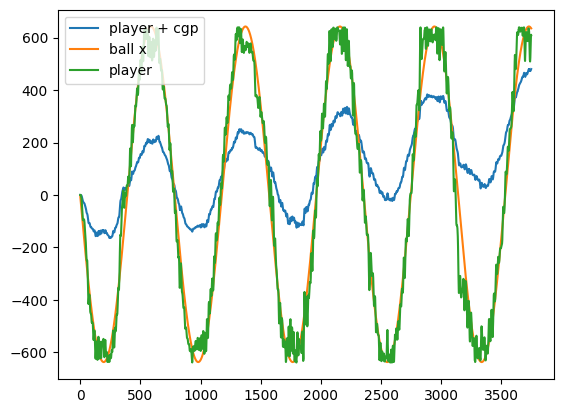

In [ ]:
# evaluate
player_pos_cgp = 0
player_pos_list = []
hist_est_dx = []
for j, t in enumerate(e.time):

    est_dx = es.father.run(e.feature[j].tolist())[0] 
    hist_est_dx.append(est_dx)

    player_pos_cgp += est_dx
    player_pos_list.append(player_pos_cgp.item())
    # print("player pos : ", player_pos_cgp)


plt.plot(player_pos_list, label = "player + cgp")
plt.plot(e.bx, label = "ball x")
plt.plot(e.px, label = "player")

plt.legend()

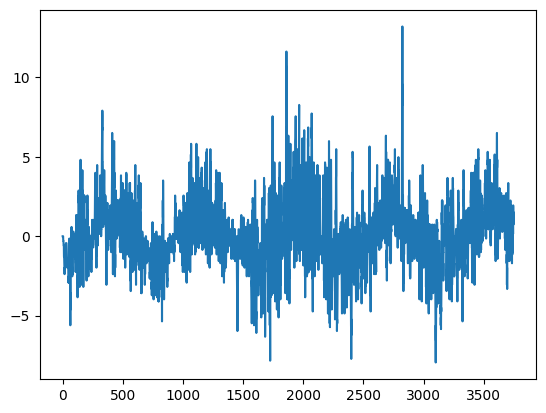

In [ ]:
plt.plot(np.array(hist_est_dx)[:, 0])
# plt.plot(e.target)
# plt.plot(e.feature[:, 0])

In [ ]:
    # output_feat = ["move", "euh"]
mdx_feat = ["mdx_{}".format(i-(Nstack-1)) for i in range(Nstack)]
mdy_feat= ["mdy_{}".format(i-(Nstack-1)) for i in range(Nstack)]

output_feat = mdx_feat.extend(mdy_feat)
print(mdx_feat) #output_feat

['mdx_-9', 'mdx_-8', 'mdx_-7', 'mdx_-6', 'mdx_-5', 'mdx_-4', 'mdx_-3', 'mdx_-2', 'mdx_-1', 'mdx_0', 'mdy_-9', 'mdy_-8', 'mdy_-7', 'mdy_-6', 'mdy_-5', 'mdy_-4', 'mdy_-3', 'mdy_-2', 'mdy_-1', 'mdy_0']
